# Detailed Troubleshooting Procedure - Server by Server

## AWS Instance

### EC2 Instance

You can get the account credentials from the Profs to log in.
Once logged in, click EC2 and ensure that the indoor localisation instance state is set as _Running_

### Security Group

The indoor Localisation project uses three main security groups: Localisation-wizard, Postgres-master & ELB_SG

#### Postgres-master

Ensure that the port 5432 is accessible by the main server (52.77.184.100) and if you need to access it, you can enable public access or private access to your ip only.

#### Localisation-wizard

I will list down some of the main ports that are needed to be made accessible:

- SSH: 22
- Jupyter: 8888
- ElasticSearch & Logstash: 9200 & 9300
- Kibana: 5601
- Load Balancer: 443
- Developer Web: 3001
- API-Server: 3000
- ZMQ Sockets for data, anchor status etc: 5000 - 6000

You can look at the user guides on AWS Security Group: https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/ec2-security-groups.html

#### ELB_SG

This security group is for the load balancer. You need to ensure there is access for port 443 (Load Balancer) and 80 (standard home page for html). For port 443, the type of connection is HTTPS. As for port 80, the type is HTTP. This can ensure the domain name page will be secured.


### Elastic IP

Elastic IP is helpful to ensure the ip address of the server does not keep changing. But do note that elastic ip will be charged a certain price to the bill. If need be, you can create new elastic ip and allocate the elastic ip to the ec2 instance. At the moment, it is set to 52.77.184.100 and shouldn't change unless something bad happens.

### Load Balancer

You can refer and follow the settings of the Localisation Load Balancer in the AWS Console to know how to set up Load Balancer. Ensure that the state is active and is using the ELB_SG security group.

### Route 53

Route 53 and Load Balancer work together to ensure the domain is valid. If the website or ip address is down, it will be mainly one of these two not working. As of now the domain name we have is _thorlocalisation.ml_. So before you enable the route 53, you will need a valid domain name. You can either get one from AWS (quite expensive) or get a free one from freenom (validity is one year).

In Route 53, you will need to key in 4 records. You can refer to the thorlocalise.ml settings for reference. Basically you will need to get the NS and SOA from AWS. And for CNAME, you will need to get validation from AWS Certificate Manager regarding your domain. Afer keying in the NS, you will need to key in these same NS into freeNom so that it matches. Finally for A, you will need to link the load balancer with the _www.domain-name.com_. But for ours, we key in the elastic ip because the load balancer couldn't work. That is why all the website starts with the elastic ip.

### FreeNom

FreeNom is used to get free domain name, but the catch is it is only valid for 1 year. So renewal is needed yearly. Currently the domain is valid till  __07/01/2023__. So each time it is expired, you will need to create a new domain name unless Profs is willing to pay the upgrade fee. To create a new domain is relatively simple. The main thing is to check its availability and link the nameservers with the one in AWS.

### Elastic Block Store

EBS is an additional volume that can be attached to the EC2 instance in the case where there is not enough volume in the internal disk space. It is relatively easy to set up the EBS, just need to choose the volume you want when creating and attach to the localisation instance. And in the instance, you will need to mount the EBS onto a folder directory. So in our case, we use 30 GB EBS and it is stored under /data directory. That is why we store our project folder under /data. The only issue with using this is it acts as an external disk space so when we install libraries or packages, we are still installing it in the internal space, which is limited in space. Thus clearing of space needs to be done regularly.

### Relational Database Service

Our Postgres is stored using the RDS service. Our API Server basically connects to this RDS to get the data. Now it is all set up, so what you need to do is just to ensure it is turned on when you are using it. Due to its high cost of RDS, it is advisable to stop it tempoarily to save cost. In the event you will need to set it up on your own, the steps are simple. I will just list down some pointers or tips when setting up.

- Choose Burstable classes when choosing DB Instance class as you would not need huge database
- Advisable to choose at least 4GB RAM
- Public Access is encouraged
- Ensure the user and password here matches the one you set up in the API Server

## API Server

The first indicator of an issue with the Postgres Server is when there is nothing displayed in the Devices page on the Developer website (52.77.184.100:3001/Devices). Or if you are unable to load any map.

Steps to resolve:
1. Check the console logging by inspect element in the browser

If there is no errors, skip step 2.

2. Rectify the error in the api-server folder

3. Check graphql and loopback explorer and try to extract information from the postgres

If there is error, do step 2.

4. Check if the postgres RDS is turned on in AWS

### Rectify the error in api-server folder

Use the error logging to find out the source and fix it. Most common errors involve files like these:
1. api-server/server/server.js
2. api-server/server/datasources.json - check if the postgresql infor is correct
3. api-server/server/config.json - check if the port is correct
4. api-server/common/models - check map.js and device.js

Once the error is fixed, to test it, you can run these scripts:

In [ ]:
"scripts": {
    "lint": "eslint .",
    "start": "node .",
    "posttest": "npm run lint && nsp check",
    "watch": "nodemon server/server.js --watch common --watch server"
  }

To know if the problem is solved, you can check these three ways:
1. Extract information from graphql and loopback
2. Navigate to 52.77.184.100:3000/api/Devices or 52.77.184.100:3000/api/Maps and see if the data is displayed
3. Check the devices page of the developer website for the devices information

If the problem is solved, you can run the server in the background by running _pm2 start postgres_



### Graphql and Loopback Explorer

#### Graphql

- Navigate to the graphql website (52.77.184.100:3000/graphql)
- Type a query to extract some information from the data
- If the results returned is correct, it meaans the API Server is set up properly
- An example of a query is shown below
- The query have to start with _query {}_
- You can use the schema on the right to guide you what fields you can search for
- You can expand each fields to see what type (int, float, string, object) the graphql is expecting

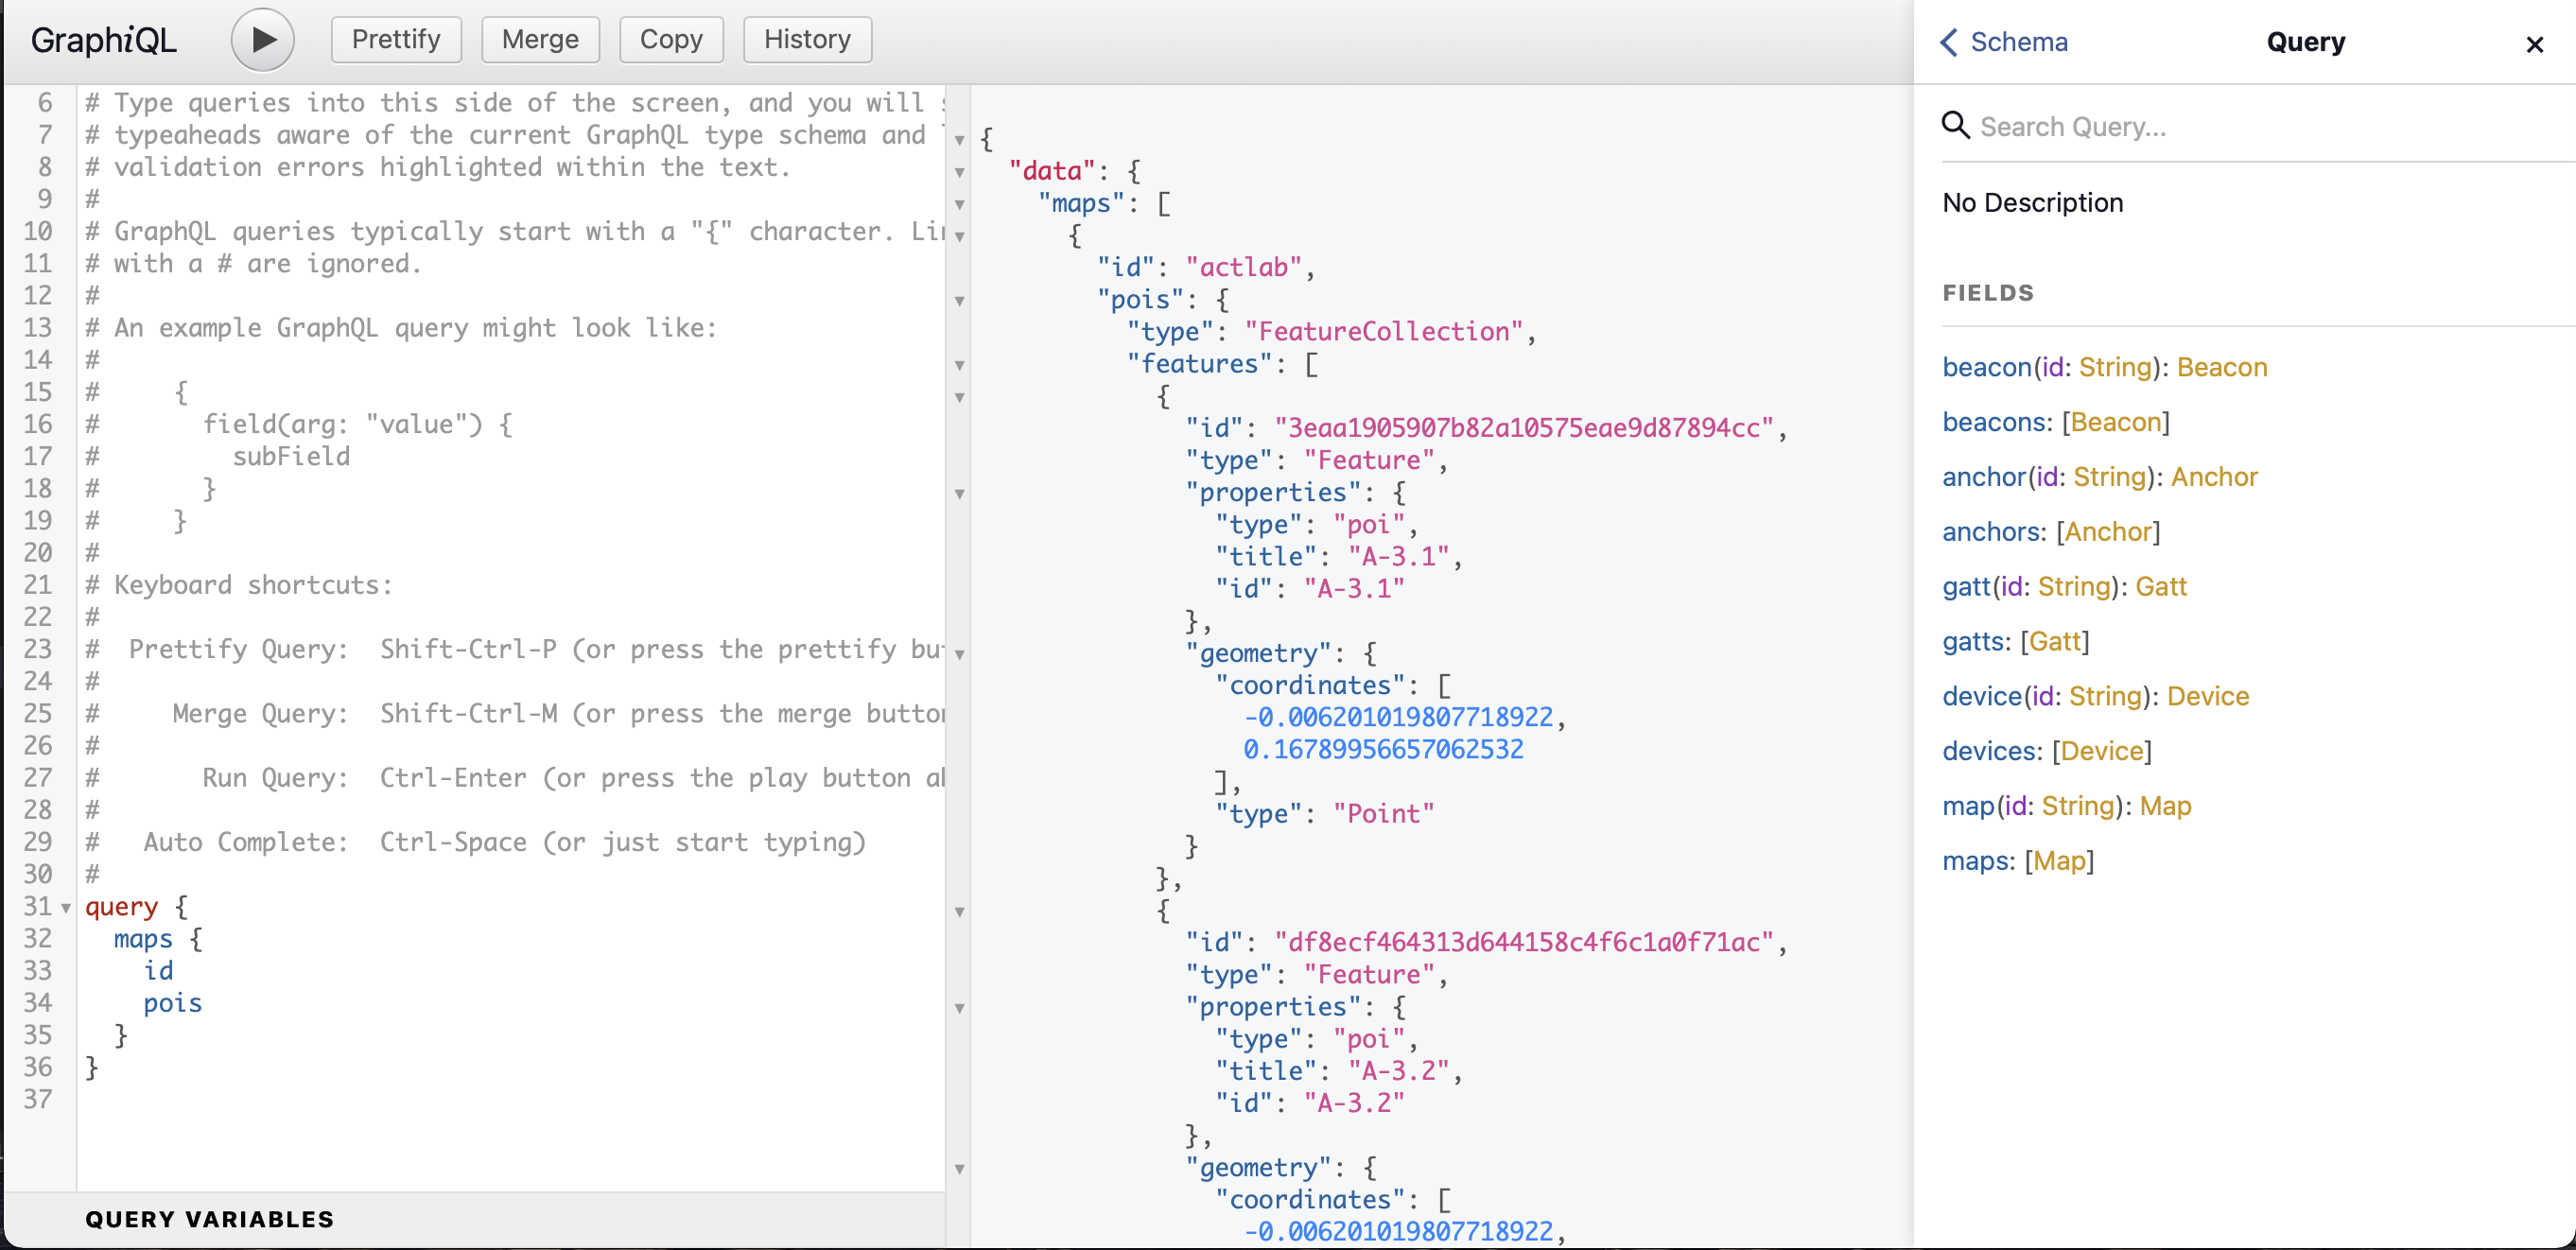

#### Loopback Explorer

- Navigate to the loopback explorer website (52.77.184.100:3000/explorer)
- Same as graphql, send a query request and expect the right result to return
- The easiest way to check, is to check for a device/map/beacon/anchor id.
- So let's say we want to search for devices id.
- you can click the part when it says GET /devices/{id}
- And key in one device id, let's say b1
- If it returns the value of b1, it means the API Server is good

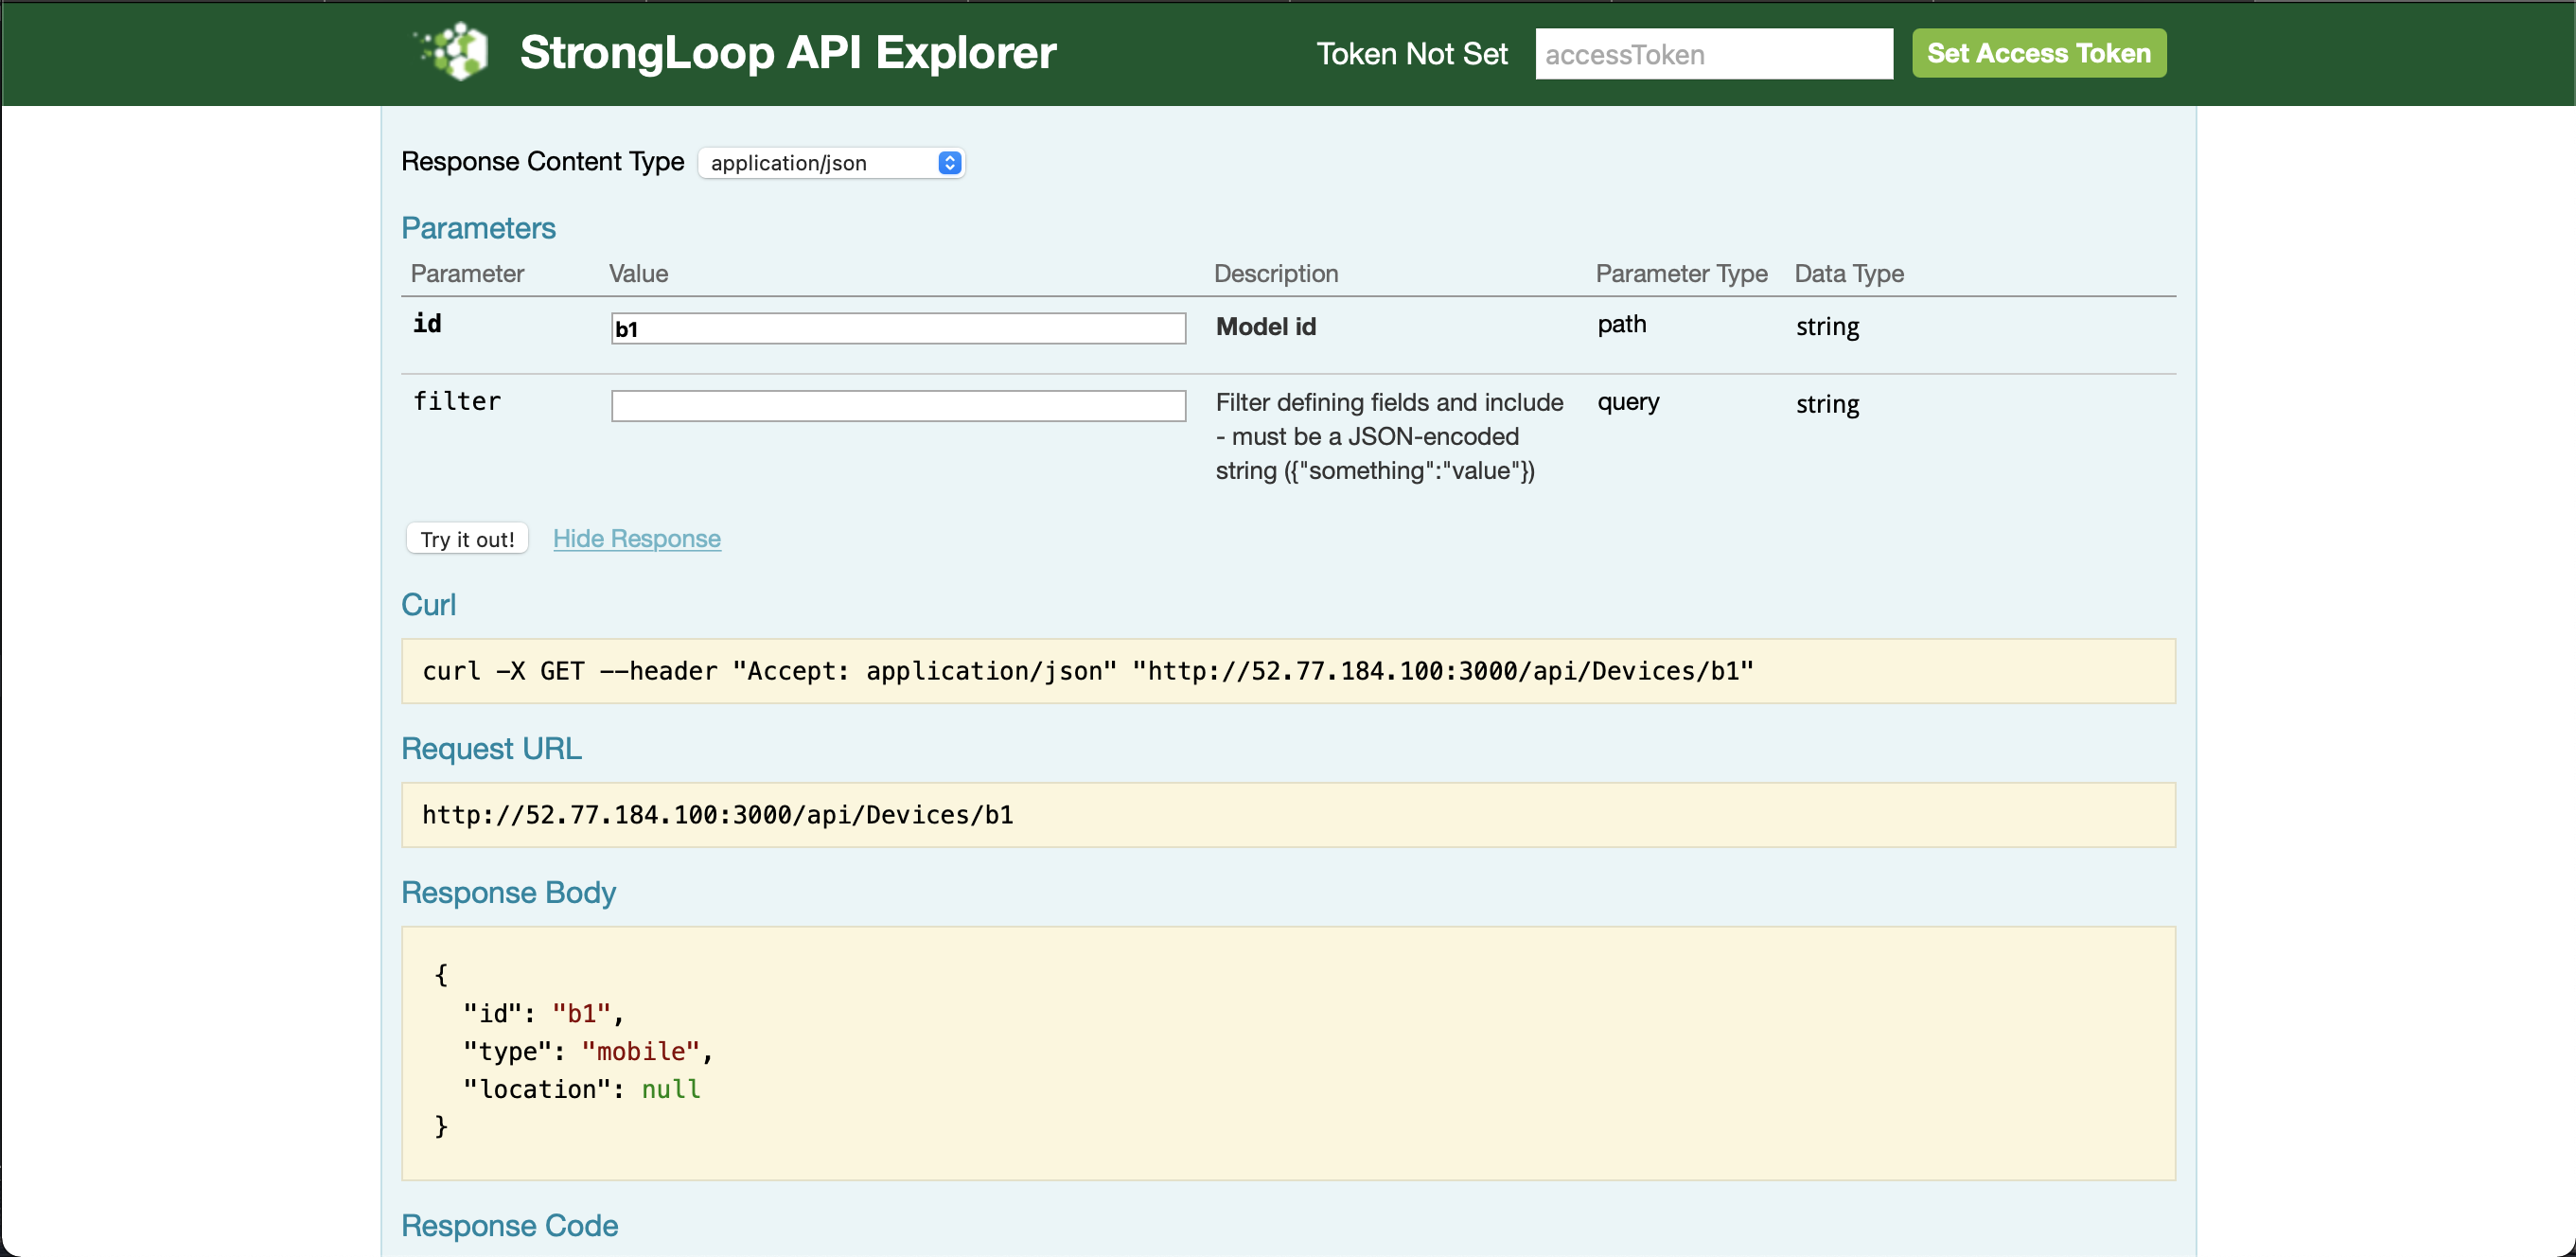

#### Other Tips

Basically how these graphical UI can work is because we connect our API Server files with our Postgres RDS, like a connector. So in our system we use Loopback Connector. 

In the event, you will need to recreate this connector. Do follow this link for guide: https://loopback.io/doc/en/lb2/Connecting-to-PostgreSQL.html#running-the-example

For the settings, do not follow their settings, use the settings we store in the API Server files. You just need to key in the commands to establish the connection.

Also, if you need to create a totally new postgres database, you can backup the database and restore it to the new database. You can use _pg_dump dbname > backupfile.sql_ to backup the database.

After which, you can run _psql -U username -f backupfile.sql_ to restore it to the new database.

For example, our localisation postgres backup is like this: _ pg_dump -U macpro indoor-localisation.c4hb7kkxkku2.ap-southeast-1.rds.amazonaws.com > localisation_backup.pgsql_

And restoration is like this: _psql --host indoor-localisation.clebjm5otlkj.ap-southeast-1.rds.amazonaws.com < postgresfile.sql_

You can follow these links for guide: 
- https://hevodata.com/learn/postgresql-dump-import/
- https://www.netguru.com/blog/how-to-dump-and-restore-postgresql-database

And if you want to view the Postgres RDS in a GUI format, you can download PGAdmin 4 and connect it to the Postgres RDS.

## Notification Server

The Notification Server manages the anchor status and position update data. So if you find the RPIs not able to send anchor status, most probably issue lies with this server. You will only need to manage one file, which is the server.js.

It is already being run in the background in the coffee object. If you need to restart it, just run _pm2 restart coffee_.

If you need to run it in foreground, stop the coffee object. And navigate to the notification server directory, and run _sudo node server.js_

You can check anchor status being sent properly by checking the logging or in Kibana.

## Development Web Server

This server manages the development website (52.77.184.100:3001). It uses javascript and React to power it up. 
Indicators to know there are errors in this server:
- the map can't load even when you click submit to load map
- Devices page doesn't show any devices after you add a device
- any of the buttons on the Devices page fail to perform
- Locate/Maps/Devices page doesn't seem to work normally

### Steps to resolve:

1. Always inspect element first to find out the error

If the problem lies in the react code, do step 2 - 4

2. Stop the background program by running _pm2 stop devWeb_
3. Navigate to the new-web-server directory
4. Run _npm start_ and check for any errors

If no errors, do step 5 - 6

5. Refresh the dev Web page and do what you were doing earlier to ensure the issue is gone
6. If issue persists, check the error logging and rectify the code if need to

Sometimes it might be database formatting issue. Like if I add a device in a wrong formatting, then there will be an issue. In that case do step 7.

7. Go into the Postgres database via PGAdmin 4 or in pgsql and remove the wrong addition data. Refreshing the dev web page will revert it to the original format. 

When you have resolved the issue, do Step 8.

8. End the _npm start_ process by using keyboard interrupt (Crtl-C).
9. Run it in the background by running _pm2 start devWeb_

If you need to recreate the pm2 background process, do these steps.

If you did change the code, you will need to rebuild the whole project files for deployment use. Do Step 10 - 12.

If you didn't change anything in the code, you only need to do step 12.

10. Run _npm build_
11. Run _sudo node server.js_ to check if it works properly
12. Run _pm2 start server.js --name devWeb_ if step 11 works

Do step 13 if you want to run the devWeb in a development use.

13. Run _pm2 start npm --name devWeb -- start_

## ELK Server

Elasticsearch is the main database where we store dynamic data such as positioning, logstash is the writer, and kibana is the visualisation to display the data in the elasticsearch

Some indicators to know there are errors:
- Kibana website (52.77.184.100:5601) display a message stating "Kibana is not ready"
    - Check Kibana & Elasticsearch
- Data are not shown in Kibana
    - Check Elasticsearch, Logstash & Notification Server
- Data are in the wrong formatting
    - Check Logstash
- Error messages appearing in the bottom right of the screen when kibana website is opened
    - Check Elasticsearch

Here is how you can resolve issues in the respective portion:

### Elasticsearch

Steps to resolve issues:
1. Check Elasticsearch status by running _sudo systemctl status elasticsearch_
2. Restart Elasticsearch by running _sudo systemctl restart elasticsearch_ to see if the error persists


The errors can vary quite a bit so I can't nail down to a specific one. But the main ones I experienced are:
- lack of disk space: Find large files or redundant files to delete from the instance. Or transfer over to the EBS if possible. Usually Log files are redundant and can be removed.
- ES ran out of space - this is different from above. This is referring to the database has reached its limit and need to remove some data. Delete old data by using ES deletion API. DO BE CAREFUL WHEN DELETING THAT YOU DON'T DELETE THE WHOLE INDEX PATTERN.
- Node failure

Data Files of ES are stored in:
- /data/var/lib/elasticsearch/nodes

Setting Config files of ES are stored in:
- /data/etc/elasticsearch/elasticsearch.yml

Systemctl Service File:
- /etc/systemd/system/elasticsearch.service

Elasticsearch Version: 7.11.1
- Navigate to 52.77.184.100:9200 to find Elasticsearch version
- Guide: https://www.elastic.co/guide/en/elasticsearch/reference/7.1/index.html

### Kibana

Steps to resolve issues:
1. Check Kibana status by running _sudo systemctl status kibana_
2. Restart Kibana by running _sudo systemctl restart kibana_ to see if the error persists

Most of the time kibana shouldn't have much issues, but in case it do, you can check and ensure the settings are correct.

Setting Config files of Kibana are stored in:
- /data/etc/kibana/kibana.yml

Systemctl Service File:
- /etc/systemd/system/kibana.service

### Logstash

Steps to resolve issues:
1. Check Kibana status by running _sudo systemctl status logstash_
2. Restart Kibana by running _sudo systemctl restart logstash_ to see if the error persists

Check the conf files to ensure all settings are correct.

Setting Config files of Kibana are stored in:
- /data/etc/logstash/logstash.yml

Systemctl Service File:
- /etc/systemd/system/logstash.service

Logstash Version: 5.6.16
- Guide: https://www.elastic.co/guide/en/logstash/5.6/introduction.html

## Algorithm Server

Only this server we need to manually run it when we need to conduct localisation experiments. The rest above mentioned are run always.

To run it in background: _pm2 start barycentric_

To run it in foreground: 
- Navigate to algorithm server directory
- Run _python3 process_barycentric_latest.py_

Usually when this have issues or errors, they are caused by other components of the server. So check all other servers are working fine first before running this code. 

If you don't see any position data, first thing is check if there are any rssi packets received. Then work backwards to rectify the issue. Check the code if there is any errors. Perhaps something you might have changed have caused the error.

Take note that the port that RPI sent to kibana and the one for algorithm server are two different ports. So if Kibana have the data doesn't mean the algorithm server received as well. In most cases, they should both received.

It is possible that this is working but the map doesn't update the location, for that you will need to check the Kibana if it received the position data.

The map takes the position data from this webpage: http://52.77.184.100:3000/api/Devices/logs

You can check if this page is updating and displaying the latest position data. If it is, the map positioning will be updated.

Once the location is updated correctly on the map, this means this server is working fine.